In [1]:
# ==========================
# 📌 Step 1: Install Dependencies
# ==========================
!pip install gymnasium shimmy stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 34.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 35.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 32.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


/usr/local/python/3.12.1/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 4.25     |
| time/              |          |
|    fps             | 1909     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | 5.87       |
| time/                   |            |
|    fps                  | 1483       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.47721714 |
|    clip_fraction        | 0.71       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.42

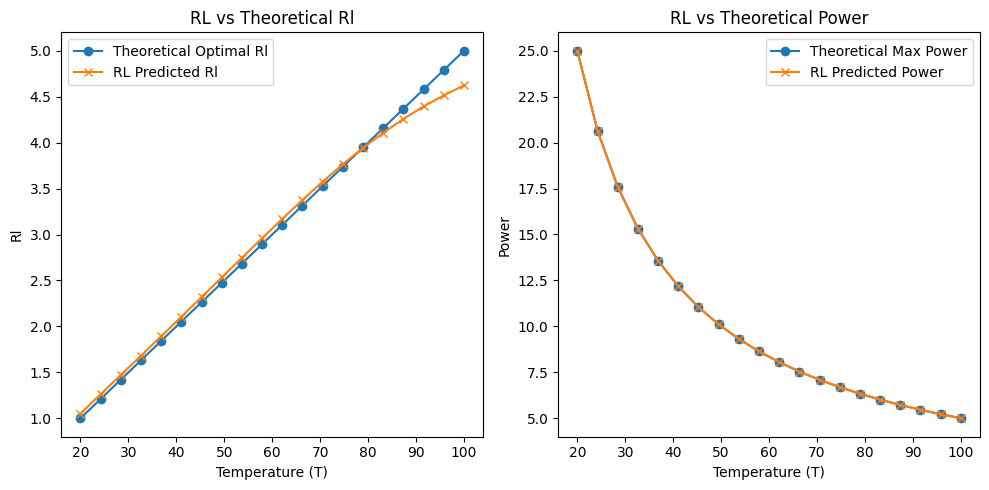

In [4]:
# ==========================
# 📌 Step 2: Import Libraries
# ==========================
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import PPO

# ==========================
# 📌 Step 3: Define RL Environment
# ==========================
class CircuitEnv(gym.Env):
    """Custom Gym environment for maximizing power in a circuit."""

    def __init__(self):
        super(CircuitEnv, self).__init__()

        # Circuit parameters
        self.V = 10  # Supply voltage
        self.alpha = 0.05  # Rs = alpha * T

        # Define state space: [Temperature, Rs]
        self.observation_space = spaces.Box(low=np.array([20, 1]),
                                            high=np.array([100, 5]),
                                            dtype=np.float32)

        # Action space: Continuous Rl selection (0.1 to 5)
        self.action_space = spaces.Box(low=np.array([0.1]), high=np.array([5.0]), dtype=np.float32)

        # Initialize state
        self.state = None

    def reset(self, seed=None, options=None):
        """Reset environment with a random temperature."""
        super().reset(seed=seed)

        T = np.random.uniform(20, 100)  # Random temp
        Rs = self.alpha * T  # Compute Rs

        self.state = np.array([T, Rs], dtype=np.float32)
        return self.state, {}  # Returning state and info dictionary

    def step(self, action):
        """Take an action (choose Rl) and return reward (power)."""
        T, Rs = self.state

        # Ensure Rl is within bounds
        Rl = np.clip(action[0], 0.1, 5)

        # Compute power
        P = (self.V**2 * Rl) / ((Rs + Rl) ** 2)

        # Reward is the power output
        reward = P

        # Done flag (single-step task)
        done = True

        return self.state, reward, done, False, {}  # Updated return format

# ==========================
# 📌 Step 4: Train RL Model
# ==========================
# Create the environment
env = CircuitEnv()

# Train PPO agent
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50000)

# Save trained model
model.save("circuit_rl_model.zip")
print("✅ Model saved as circuit_rl_model.zip")

# ==========================
# 📌 Step 5: Validate Model (Compare with Theoretical Values)
# ==========================
def theoretical_max_power(V, Rs):
    """Compute theoretical max power based on Rs."""
    Rl_opt = Rs  # From max power transfer theorem
    P_max = (V**2) / (4 * Rs)
    return Rl_opt, P_max

# Test the model
temperatures = np.linspace(20, 100, 20)  # Test on 20 points
predicted_rl = []
true_rl = []
predicted_power = []
true_power = []

for T in temperatures:
    Rs = env.alpha * T
    obs = np.array([T, Rs], dtype=np.float32)

    # RL model prediction
    action, _ = model.predict(obs, deterministic=True)
    Rl_rl = np.clip(action[0], 0.1, 5)  # Keep within valid range
    P_rl = (env.V**2 * Rl_rl) / ((Rs + Rl_rl) ** 2)

    # Theoretical max power
    Rl_opt, P_max = theoretical_max_power(env.V, Rs)

    # Store results
    predicted_rl.append(Rl_rl)
    true_rl.append(Rl_opt)
    predicted_power.append(P_rl)
    true_power.append(P_max)

# ==========================
# 📌 Step 6: Plot Results
# ==========================
plt.figure(figsize=(10, 5))

# Rl Comparison
plt.subplot(1, 2, 1)
plt.plot(temperatures, true_rl, label="Theoretical Optimal Rl", marker="o")
plt.plot(temperatures, predicted_rl, label="RL Predicted Rl", marker="x")
plt.xlabel("Temperature (T)")
plt.ylabel("Rl")
plt.title("RL vs Theoretical Rl")
plt.legend()

# Power Comparison
plt.subplot(1, 2, 2)
plt.plot(temperatures, true_power, label="Theoretical Max Power", marker="o")
plt.plot(temperatures, predicted_power, label="RL Predicted Power", marker="x")
plt.xlabel("Temperature (T)")
plt.ylabel("Power")
plt.title("RL vs Theoretical Power")
plt.legend()

plt.tight_layout()
plt.show()

# # ==========================
# # 📌 Step 7: Download Trained Model (Optional)
# # ==========================
# from google.colab import files
# files.download("circuit_rl_model.zip")
# print("✅ Model downloaded successfully!")


In [5]:
# Print all predicted and theoretical values
print("\n📌 Comparison of RL Predictions vs. Theoretical Values\n")
print(f"{'Temperature':<12}{'RL Predicted':<15}{'RL Theoretical':<15}{'Power Predicted':<20}{'Power Theoretical':<20}")
print("="*80)

for i in range(len(temperatures)):
    print(f"{temperatures[i]:<12.2f}{predicted_rl[i]:<15.4f}{true_rl[i]:<15.4f}{predicted_power[i]:<20.4f}{true_power[i]:<20.4f}")



📌 Comparison of RL Predictions vs. Theoretical Values

Temperature RL Predicted   RL Theoretical Power Predicted     Power Theoretical   
20.00       1.0520         1.0000         24.9839             25.0000             
24.21       1.2629         1.2105         20.6429             20.6522             
28.42       1.4726         1.4211         17.5870             17.5926             
32.63       1.6825         1.6316         15.3190             15.3226             
36.84       1.8935         1.8421         13.5689             13.5714             
41.05       2.1057         2.0526         12.1775             12.1795             
45.26       2.3190         2.2632         11.0449             11.0465             
49.47       2.5331         2.4737         10.1050             10.1064             
53.68       2.7472         2.6842         9.3125              9.3137              
57.89       2.9603         2.8947         8.6353              8.6364              
62.11       3.1708         3.10